In [2]:
import pandas as pd

In [3]:
readings_summary  = pd.read_csv("readings_summary_raw.csv")
stations_to_keep = readings_summary[readings_summary['Percentage of Month (%)']>84.99]['randid'].unique().tolist()

df = pd.read_csv("../Data/PV_data_clean.csv")
df = df[df['randid'].isin(stations_to_keep)]

df["solar_power_plant"] = df["NOAAClimRegion"] + "_" + df["TempZone"] + "_" + df["HumidZone"] + "_" + df["bin_PlantSize_kW"].apply(lambda x: x[0])
pca_vals = pd.read_csv("../Data/solar_plant_pca_values.csv")

df_with_pca = df.merge(pca_vals, on='solar_power_plant', how='left')
df_with_pca.to_csv("../Data/clean_data_with_pca.csv",index=False)

C:\Users\loolz\AppData\Local\Temp\ipykernel_20300\4258933458.py:4: DtypeWarning: Columns (8,9,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../Data/PV_data_clean.csv")


## Linear Regression

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35391 entries, 0 to 35539
Data columns (total 40 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   randid                    35391 non-null  object 
 1   Date                      35391 non-null  object 
 2   NOAAClimRegion            35391 non-null  object 
 3   TempZone                  35391 non-null  object 
 4   HumidZone                 35391 non-null  object 
 5   bin_PlantSize_kW          35391 non-null  object 
 6   plant_age_months          35391 non-null  float64
 7   active_snow_tickets       35391 non-null  object 
 8   snow_bin_ticket_minutes   577 non-null    object 
 9   snow_affected_assets      577 non-null    object 
 10  snow_production_level     35391 non-null  object 
 11  PR                        35391 non-null  float64
 12  snow_value_mm             35391 non-null  float64
 13  total_daily_snow_mm       35391 non-null  float64
 14  low_irradia

In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
df['power_outage'] = (df['PR'] < 0.1).astype(int)

# Drop the original 'PR' column as it's directly used to create the target
df = df.drop('PR', axis=1)

# Ensure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract time-based features from 'Date'
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day_of_week'] = df['Date'].dt.dayofweek
df['day_of_year'] = df['Date'].dt.dayofyear
df['hour'] = df['Date'].dt.hour

# Drop original 'Date' and 'randid' as they are not direct features for the model
# Assuming 'randid' exists; if not, remove it from this line.
if 'randid' in df.columns:
    df = df.drop(['Date', 'randid'], axis=1)
else:
    df = df.drop(['Date'], axis=1)


# Identify numerical and categorical features
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()

# Remove the target variable from numerical features list
if 'power_outage' in numerical_features:
    numerical_features.remove('power_outage')

print(f"Numerical Features: {numerical_features}")
print(f"Categorical Features: {categorical_features}")
print("\n")

Numerical Features: ['plant_age_months', 'snow_value_mm', 'total_daily_snow_mm', 'low_irradiation', 'cumulative_snow_mm', 'hurricane', 'nearest_hurricane', 'wind_speed_mean', 'rain_value_mm', 'nearest_rain', 'lightning', 'storm', 'duration_minutes_storm', 'nearest_storm', 'flood', 'duration_minutes_flood', 'nearest_flood', 'rain', 'weather_onset', 'year', 'month', 'day_of_week', 'day_of_year', 'hour']
Categorical Features: ['NOAAClimRegion', 'TempZone', 'HumidZone', 'bin_PlantSize_kW', 'active_snow_tickets', 'snow_bin_ticket_minutes', 'snow_affected_assets', 'snow_production_level', 'hurr_bin_ticket_minutes', 'hurr_affected_assets', 'hurr_production_level', 'HurricanePrep', 'HurricanePostInspection', 'storm_active_tickets', 'storm_bin_ticket_minutes', 'storm_affected_assets', 'storm_production_level', 'solar_power_plant']




In [65]:
df.columns

Index(['NOAAClimRegion', 'TempZone', 'HumidZone', 'bin_PlantSize_kW',
       'plant_age_months', 'active_snow_tickets', 'snow_bin_ticket_minutes',
       'snow_affected_assets', 'snow_production_level', 'snow_value_mm',
       'total_daily_snow_mm', 'low_irradiation', 'cumulative_snow_mm',
       'hurr_bin_ticket_minutes', 'hurr_affected_assets',
       'hurr_production_level', 'HurricanePrep', 'HurricanePostInspection',
       'hurricane', 'nearest_hurricane', 'wind_speed_mean', 'rain_value_mm',
       'nearest_rain', 'storm_active_tickets', 'storm_bin_ticket_minutes',
       'storm_affected_assets', 'storm_production_level', 'lightning', 'storm',
       'duration_minutes_storm', 'nearest_storm', 'flood',
       'duration_minutes_flood', 'nearest_flood', 'rain', 'weather_onset',
       'solar_power_plant', 'power_outage', 'year', 'month', 'day_of_week',
       'day_of_year', 'hour'],
      dtype='object')

In [67]:
# --- 3. Advanced Feature Selection ---

# 3.2 Remove features with too many missing values (e.g., > 80%)
initial_features = numerical_features + categorical_features
features_to_drop_high_missing = []
for col in initial_features:
    if df[col].isnull().sum() / len(df) > 0.8: # Threshold for high missingness
        features_to_drop_high_missing.append(col)
        print(f"Dropping '{col}' due to high missing value percentage.")

df = df.drop(columns=features_to_drop_high_missing)
df_original = df.copy()
numerical_features = [f for f in numerical_features if f not in features_to_drop_high_missing]
categorical_features = [f for f in categorical_features if f not in features_to_drop_high_missing]


# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()) # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])

# Create a preprocessor that applies transformations to different column types
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns (like PC2, PC3 if not explicitly handled)
)

# Split data into training and testing sets
X = df.drop('power_outage', axis=1)
y = df['power_outage']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply preprocessing to training data to get transformed feature names
X_train_processed = preprocessor.fit_transform(X_train)
# Get feature names after one-hot encoding
# Ensure 'categorical_features' is not empty before calling get_feature_names_out
if categorical_features:
    ohe_feature_names = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
else:
    ohe_feature_names = [] # No categorical features to get names from

all_transformed_features = numerical_features + list(ohe_feature_names)

# Convert processed data back to DataFrame for feature selection steps
# Handle cases where all_transformed_features might be empty if no features are left
if not all_transformed_features:
    raise ValueError("No features remaining after initial preprocessing and missing value handling. Please check your data.")

X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_transformed_features, index=X_train.index)
X_test_processed = preprocessor.transform(X_test)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_transformed_features, index=X_test.index)


# 3.3 Variance Threshold (after imputation and scaling)
# Remove features with low variance (e.g., constant features)
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.01) # Remove features with variance less than 0.01
X_train_vt = selector.fit_transform(X_train_processed_df)
selected_features_vt = X_train_processed_df.columns[selector.get_support()]
print(f"Features after Variance Threshold: {len(selected_features_vt)} features selected.")
X_train_processed_df = X_train_processed_df[selected_features_vt]
X_test_processed_df = X_test_processed_df[selected_features_vt]

if X_train_processed_df.empty:
    raise ValueError("No features remaining after Variance Threshold. Adjust threshold or check data.")


# 3.4 SelectKBest (Univariate Feature Selection)
# Select top K features based on ANOVA F-value (suitable for classification target)
# Ensure k is not greater than the number of available features
k_to_select = min(20, X_train_processed_df.shape[1])
k_best_selector = SelectKBest(f_classif, k=k_to_select)
X_train_kbest = k_best_selector.fit_transform(X_train_processed_df, y_train)
selected_features_kbest = X_train_processed_df.columns[k_best_selector.get_support()]
print(f"Features after SelectKBest: {len(selected_features_kbest)} features selected.")
X_train_processed_df = X_train_processed_df[selected_features_kbest]
X_test_processed_df = X_test_processed_df[selected_features_kbest]

if X_train_processed_df.empty:
    raise ValueError("No features remaining after SelectKBest. Adjust k or check data.")

# 3.5 Lasso Regression for Feature Selection (L1 Regularization)
# Lasso can shrink coefficients of less important features to zero, effectively selecting features.
# We'll use LassoCV to find the optimal alpha (regularization strength).
lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso.fit(X_train_processed_df, y_train)

# Get features with non-zero coefficients
selected_features_lasso = X_train_processed_df.columns[lasso.coef_ != 0]
print(f"Features after Lasso Regression: {len(selected_features_lasso)} features selected.")

if len(selected_features_lasso) == 0:
    raise ValueError("Lasso Regression selected no features. Consider adjusting Lasso parameters or feature scaling.")

X_train_final = X_train_processed_df[selected_features_lasso]
X_test_final = X_test_processed_df[selected_features_lasso]


# 3.6 Recursive Feature Elimination (RFE)
# RFE works by recursively fitting a model and eliminating the worst or least important feature.
# We'll use LinearRegression as the base estimator.
# Note: RFE can be computationally intensive with many features.
# We will apply RFE on the features already selected by Lasso for efficiency.
estimator = LinearRegression()
# Ensure n_features_to_select is not greater than the number of features available after Lasso
n_features_rfe = min(10, X_train_final.shape[1])
if n_features_rfe == 0:
    raise ValueError("No features available for RFE after Lasso. Check previous feature selection steps.")

rfe_selector = RFE(estimator=estimator, n_features_to_select=n_features_rfe, step=1)
rfe_selector.fit(X_train_final, y_train)
selected_features_rfe = X_train_final.columns[rfe_selector.get_support()]
print(f"Features after RFE: {len(selected_features_rfe)} features selected.")

# Final set of features to use for the model
if len(selected_features_rfe) == 0:
    raise ValueError("RFE selected no features. Consider adjusting RFE parameters or previous feature selection steps.")

X_train_model = X_train_final[selected_features_rfe]
X_test_model = X_test_final[selected_features_rfe]

print("\nFinal Features selected for the Linear Regression Model:")
print(selected_features_rfe.tolist())


Dropping 'snow_bin_ticket_minutes' due to high missing value percentage.
Dropping 'snow_affected_assets' due to high missing value percentage.
Dropping 'hurr_bin_ticket_minutes' due to high missing value percentage.
Dropping 'hurr_affected_assets' due to high missing value percentage.
Dropping 'storm_bin_ticket_minutes' due to high missing value percentage.
Dropping 'storm_affected_assets' due to high missing value percentage.
Features after Variance Threshold: 68 features selected.
Features after SelectKBest: 20 features selected.
Features after Lasso Regression: 19 features selected.
Features after RFE: 10 features selected.

Final Features selected for the Linear Regression Model:
['lightning', 'NOAAClimRegion_Upper Midwest', 'NOAAClimRegion_West', 'TempZone_T4', 'TempZone_T6', 'TempZone_T7', 'HumidZone_H3', 'bin_PlantSize_kW_small', 'solar_power_plant_West_T4_H4_s', 'solar_power_plant_West_T6_H4_l']


In [66]:
# --- 4. Model Training ---
print("\nTraining Linear Regression Model...")
linear_model = LinearRegression()
linear_model.fit(X_train_model, y_train)
print("Model training complete.")

# --- 5. Evaluation ---
y_pred_train = linear_model.predict(X_train_model)
y_pred_test = linear_model.predict(X_test_model)

# Evaluate on training set
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

print("\n--- Model Evaluation on Training Set ---")
print(f"Root Mean Squared Error (RMSE): {rmse_train:.4f}")
print(f"Mean Absolute Error (MAE): {mae_train:.4f}")
print(f"R-squared (R2): {r2_train:.4f}")

# Evaluate on test set
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("\n--- Model Evaluation on Test Set ---")
print(f"Root Mean Squared Error (RMSE): {rmse_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"R-squared (R2): {r2_test:.4f}")

# Display model coefficients
print("\nModel Coefficients:")
for feature, coef in zip(X_train_model.columns, linear_model.coef_):
    print(f"{feature}: {coef:.4f}")
print(f"Intercept: {linear_model.intercept_:.4f}")


Training Linear Regression Model...
Model training complete.

--- Model Evaluation on Training Set ---
Root Mean Squared Error (RMSE): 0.3314
Mean Absolute Error (MAE): 0.2227
R-squared (R2): 0.2324

--- Model Evaluation on Test Set ---
Root Mean Squared Error (RMSE): 0.3319
Mean Absolute Error (MAE): 0.2239
R-squared (R2): 0.2302

Model Coefficients:
lightning: 0.0812
NOAAClimRegion_Upper Midwest: 0.1926
NOAAClimRegion_West: -0.1066
TempZone_T4: -0.0015
TempZone_T6: -0.0759
TempZone_T7: 0.5054
HumidZone_H3: 0.2420
bin_PlantSize_kW_small: 0.1255
solar_power_plant_West_T4_H4_s: 0.4984
solar_power_plant_West_T6_H4_l: 0.0751
Intercept: 0.1343



--- Interpreting Power Outage Likelihood ---
The linear regression model outputs a continuous value. Since our target 'power_outage' is binary (0 or 1),
you can interpret the model's output as a 'likelihood' or 'score'.
A higher predicted value indicates a higher likelihood of a power outage (PR < 0.1).

--- Classification Metrics (using threshold = 0.5) ---
Accuracy: 0.8532
Precision: 0.8100
Recall: 0.1984
F1-Score: 0.3187

Confusion Matrix:
[[5797   57]
 [ 982  243]]


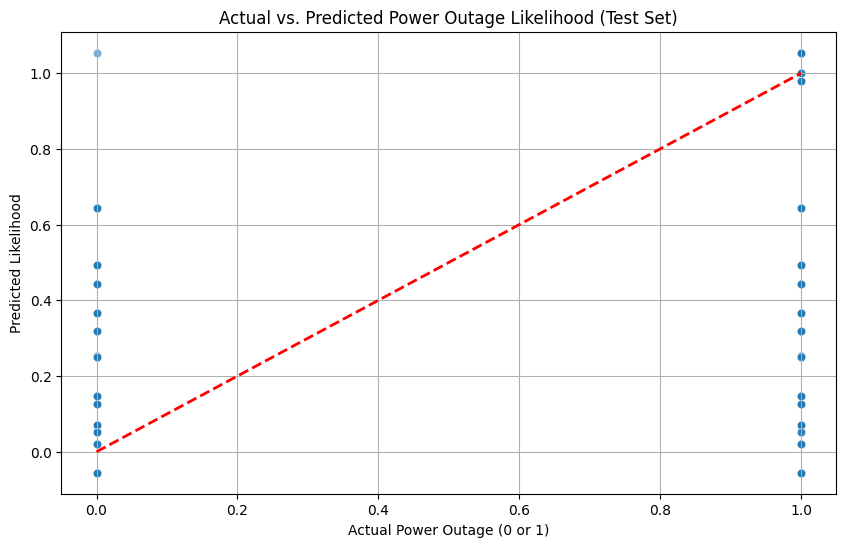

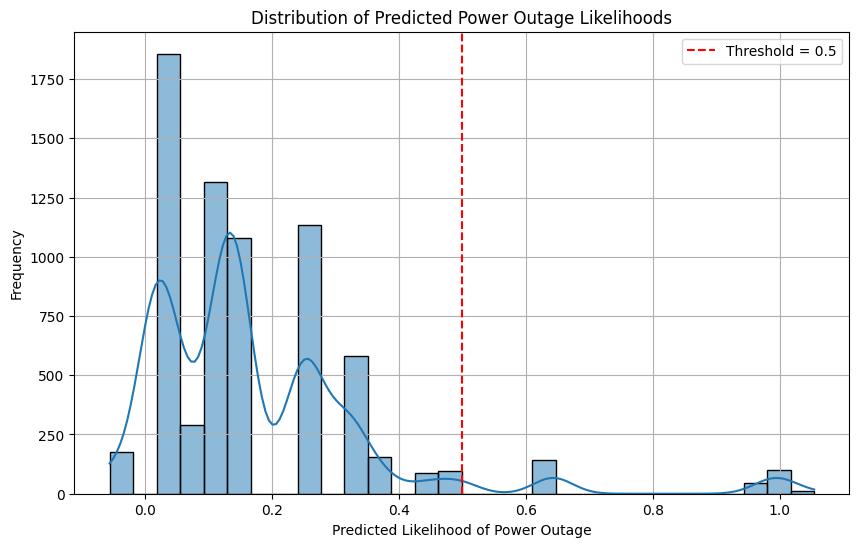

In [75]:
# --- Interpretation of Results for Power Outage Likelihood ---
print("\n--- Interpreting Power Outage Likelihood ---")
print("The linear regression model outputs a continuous value. Since our target 'power_outage' is binary (0 or 1),")
print("you can interpret the model's output as a 'likelihood' or 'score'.")
print("A higher predicted value indicates a higher likelihood of a power outage (PR < 0.1).")

# To convert to a binary prediction, you would typically set a threshold.
# For example, if the predicted value is >= 0.5, classify as a power outage.
threshold = 0.5
y_pred_binary = (y_pred_test >= threshold).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print(f"\n--- Classification Metrics (using threshold = {threshold}) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_binary):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_binary):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_binary):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_binary):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_binary))

# Plotting predicted vs actual values for visual inspection
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("Actual Power Outage (0 or 1)")
plt.ylabel("Predicted Likelihood")
plt.title("Actual vs. Predicted Power Outage Likelihood (Test Set)")
plt.grid(True)
plt.show()

# Plotting distribution of predicted likelihoods
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_test, bins=30, kde=True)
plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold = {threshold}')
plt.xlabel("Predicted Likelihood of Power Outage")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Power Outage Likelihoods")
plt.legend()
plt.grid(True)
plt.show()